In [1]:
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *

In [2]:
def get_labeled_data(picklename, bTrain = True):
    """Read input-vector (image) and target class (label, 0-9) and return
       it as list of tuples.
    """
    if os.path.isfile('%s.pickle' % picklename):
        data = pickle.load(open('%s.pickle' % picklename, 'rb'))
    else:
        # Open the images with gzip in read binary mode
        if bTrain:
            images = open(MNIST_data_path + 'train-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 'train-labels.idx1-ubyte','rb')
        else:
            images = open(MNIST_data_path + 't10k-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 't10k-labels.idx1-ubyte','rb')
        # Get metadata for images
        images.read(4)  # skip the magic_number
        number_of_images = unpack('>I', images.read(4))[0]
        rows = unpack('>I', images.read(4))[0]
        cols = unpack('>I', images.read(4))[0]
        # Get metadata for labels
        labels.read(4)  # skip the magic_number
        N = unpack('>I', labels.read(4))[0]

        if number_of_images != N:
            raise Exception('number of labels did not match the number of images')
        # Get the data
        x = np.zeros((N, rows, cols), dtype=np.uint8)  # Initialize numpy array
        y = np.zeros((N, 1), dtype=np.uint8)  # Initialize numpy array
        for i in range(N):
            if i % 1000 == 0:
                print("i: %i" % i)
            x[i] = [[unpack('>B', images.read(1))[0] for unused_col in range(cols)]  for unused_row in range(rows) ]
            y[i] = unpack('>B', labels.read(1))[0]

        data = {'x': x, 'y': y, 'rows': rows, 'cols': cols}
        pickle.dump(data, open("%s.pickle" % picklename, "wb"), encoding='bytes')
    return data

In [3]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
    print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def get_2d_input_weights(name, shape):       # (L_x*L_x, L_y*L_y) into (L_x*L_y, L_x*L_y)
    L_x = shape[0]
    L_y = shape[1]
    L_x_sqrt = int(np.sqrt(shape[0]))
    L_y_sqrt = int(np.sqrt(shape[1]))
    num_values_col = L_x_sqrt*L_y_sqrt
    num_values_row = num_values_col
    rearranged_weights = np.zeros((num_values_col, num_values_row))
    connMatrix = np.zeros((L_x, L_y))
    connMatrix[connections[name].i, connections[name].j] = connections[name].w
    weight_matrix = np.copy(connMatrix)
    
    for i in range(L_y_sqrt):
        for j in range(L_y_sqrt):
                rearranged_weights[i*L_x_sqrt : (i+1)*L_x_sqrt, j*L_x_sqrt : (j+1)*L_x_sqrt] = weight_matrix[:, i + j*L_y_sqrt].reshape((L_x_sqrt, L_x_sqrt))
    return rearranged_weights

def plot_2d_input_weights(name, shape, fig_num):
    weights = get_2d_input_weights(name, shape)
    fig = figure(fig_num, figsize = (10, 10))
    im2 = imshow(weights, interpolation = "nearest", vmin = 0, vmax = wmax, cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('weights of connection' + name)
    fig.canvas.draw()
    return im2, fig

def update_2d_input_weights(name, shape, previous_figure):
    im = previous_figure[0]
    fig = previous_figure[1]
    weights = get_2d_input_weights(name, shape)
    im.set_array(weights)
    fig.canvas.draw()
    return im

In [5]:
def plot_one_to_one(name, size, fig_num):
    L1_x = int(np.sqrt(size))
    L1_y = L1_x
    rearranged_weights = np.zeros((L1_x, L1_y))
    weights_copy = np.copy(connections[name].w)

    for i in range(L1_x):
        for j in range(L1_y):
            rearranged_weights[i,j] = weights_copy[(L1_x*i+j)*(size+1)]

    fig = figure(fig_num, figsize = (10, 10))
    im2 = imshow(rearranged_weights, interpolation = "nearest", vmin = 0, vmax = wmax, cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('weights of connection' + name)
    fig.canvas.draw()    

In [6]:
def plot_spike_counts(name, layer_shape, fig_num):
    layer_shape = (28,28)
    x_L = layer_shape[0]
    y_L = layer_shape[1]
    spike_copy = np.copy(spike_monitors[name].count)
    spike_matrix = np.zeros(layer_shape)
    for i in range(y_L):
        for j in range(x_L):
            spike_matrix[i,j] = spike_copy[i*x_L + j]

    unique_list = unique(spike_matrix)
    max_val = max(unique_list)
    min_val = min(unique_list)

    fig = figure(fig_num, figsize = (10, 10))
    im2 = imshow(spike_matrix, interpolation = "nearest", vmin = min_val, vmax = max_val , cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('number of spikes - ' + name + ' layer')

In [7]:
def normalize_weights():
    for connName in connections:                                             # XeAe, AeAi, AiAe
        len_source = len(connections[connName].source)                   # 784 = 28*28
        len_target = len(connections[connName].target)                   # 225 = 15*15
        connection = np.zeros((len_source, len_target))                  # (784,225)
        connection[connections[connName].i, connections[connName].j] = connections[connName].w
        temp_conn = np.copy(connection)                                  # why make temp ???????????
        colSums = np.sum(temp_conn, axis = 0)
        colFactors = weight[connName]/colSums                         # 78.0/value of each n_e neuron sum
        for j in range(len_target):                  # for each n_e
            temp_conn[:,j] *= colFactors[j]   # weight = (weight*78.0) / (sum of input weights for each n_e neuron)
        connections[connName].w = temp_conn[connections[connName].i, connections[connName].j]

# Code

In [8]:
n_input = 784
n_L3 = n_input
n_L2 = n_L3

dataset_size = 1
num_examples = dataset_size * 10

single_example_time = 0.35 * second
resting_time = 0.15 * second

# weight values ????????????????????/
# weight = {}
# weight['ee_input'] = 78.                       # initial weights
weight = {}
weight['input_L3'] = 70.                      # excitation one to one connection
weight['L3_L3'] = 0.2                         # excitation one to all horizontal connection
weight['L3_L2'] = 10.4                        # excitation one to one connection
weight['L2_L3'] = 17.0                        # inhibition one to all backward connection (except predecessor)

delay = {}
delay['ee_input'] = (0*ms, 10*ms)              # min and max delay
minDelay = delay['ee_input'][0]
maxDelay = delay['ee_input'][1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 20*ms
tc_post_1 = 20*ms
tc_post_2 = 40*ms
nu_pre =  0.0001
nu_post = 0.01
wmax = 100.0

input_intensity = 2.
start_input_intensity = input_intensity


# weight_update_interval = int(num_examples / 20)    #
# save_connections_interval = int(num_examples / 5)  #
# update_interval = int(num_examples / 5)            #
weight_update_interval = 2
save_connections_interval = 2
update_interval = 2

In [9]:
MNIST_data_path = './MINST/'
weight_path = './experiment_2/random/'
np.random.seed(0)

In [10]:
start = time.time()
training = get_labeled_data(MNIST_data_path + 'training')
end = time.time()
print('time needed to load training set:', end - start)

time needed to load training set: 0.40651726722717285


In [11]:
training['x'] = training['x'][0]    # this is digit "5"
training['y'] = training['y'][0]

In [12]:
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
# v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
# v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

# neuron_eqs_i = '''
#         dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
#         dg_e/dt = -g_e/(1.0*ms)                                    : 1
#         dg_i/dt = -g_i/(2.0*ms)                                    : 1
# '''

neuron_groups = {}
neuron_groups['L3'] = NeuronGroup(n_L3, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
# neuron_groups['L2'] = NeuronGroup(n_L2, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')

neuron_groups['L3'].v = v_rest_e - 40.*mV
# neuron_groups['L2'].v = v_rest_i - 40.*mV

neuron_groups['L3'].theta = np.ones((n_L3)) * 20.0*mV

input_group = PoissonGroup(n_input, 0*Hz)

In [13]:
input_group

PoissonGroup(784, rates=0. * hertz)

In [14]:
neuron_groups['L3']

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

In [15]:
# without STDP
model = 'w : 1'
pre = 'g_e_post += w'
post = ''

# with STDP
stdp_model = '''
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost1/dt  = -post1/(tc_post_1)     : 1 (event-driven)
    dpost2/dt  = -post2/(tc_post_2)     : 1 (event-driven)
'''
stdp_pre = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_e_post += w;'
stdp_post = 'post1 = 1.; post2 = 1.; w = clip(w + nu_post * pre * post2, 0, wmax)'


connections = {}

# input to L3 connection without STDP
# one to one connection

weightMatrix = get_matrix_from_file(weight_path + 'input_L3.npy', (784,784))

connections['input_L3'] = Synapses(input_group, neuron_groups['L3'], model=stdp_model, on_pre=stdp_pre, on_post=stdp_post)
connections['input_L3'].connect(True)
connections['input_L3'].w = weightMatrix[connections['input_L3'].i, connections['input_L3'].j]
# connections['input_L3'].w = np.ones((n_input,))*78
connections['input_L3'].delay = 'minDelay + rand() * deltaDelay'  

# # L3 to L3 connection with STDP
# # one-to-all connection

# weightMatrix = get_matrix_from_file(weight_path + '/L3_L3.npy', (784,784))

# connections['L3_L3'] = Synapses(neuron_groups['L3'], neuron_groups['L3'], model=stdp_model, on_pre=stdp_pre, on_post=stdp_post)
# connections['L3_L3'].connect(True)
# connections['L3_L3'].w = weightMatrix[connections['L3_L3'].i, connections['L3_L3'].j]
# connections['L3_L3'].delay = 'minDelay + rand() * deltaDelay'  

# # L3 to L2 connection with STDP
# # one-to-one connection

# weightMatrix = get_matrix_from_file(weight_path + '/L3_L2.npy', (784,784))

# connections['L3_L2'] = Synapses(neuron_groups['L3'], neuron_groups['L2'], model=stdp_model, on_pre=stdp_pre, on_post=stdp_post)
# connections['L3_L2'].connect(True)
# connections['L3_L2'].w = weightMatrix[connections['L3_L2'].i, connections['L3_L2'].j]
# connections['L3_L2'].delay = 'minDelay + rand() * deltaDelay'  

# # L2 to L3 connection with STDP
# # one-to-one connection

# weightMatrix = get_matrix_from_file(weight_path + '/L2_L3.npy', (784,784))

# connections['L2_L3'] = Synapses(neuron_groups['L2'], neuron_groups['L3'], model=stdp_model, on_pre=stdp_pre, on_post=stdp_post)
# connections['L2_L3'].connect(True)
# connections['L2_L3'].w = weightMatrix[connections['L2_L3'].i, connections['L2_L3'].j]
# connections['L2_L3'].delay = 'minDelay + rand() * deltaDelay'  


(784, 3) ./experiment_2/random/input_L3.npy


WARNING    C:\Users\Lahiru Sampath\Anaconda3\envs\sim\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Lahiru Sampath\.cython\brian_extensions\_cython_magic_6c7383c4a9c0ce537c1ebc1b23c41d38.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
  tree = Parsing.p_module(s, pxd, full_module_name)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codege

WARNING    C:\Users\Lahiru Sampath\Anaconda3\envs\sim\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
 [py.warnings]
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "



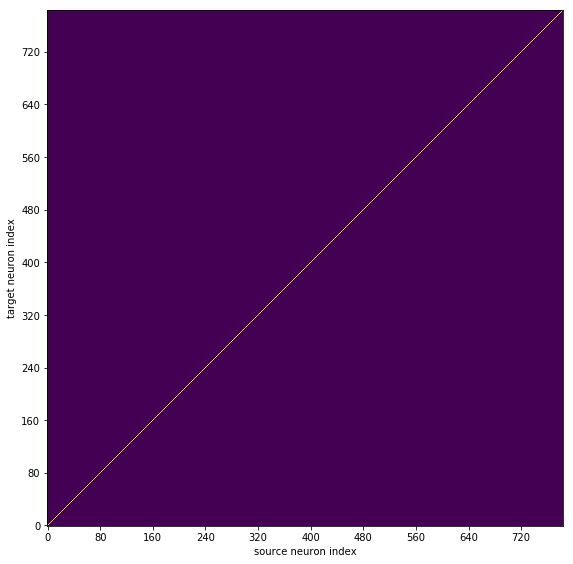

In [16]:
plt.figure(5, figsize=(10,10))
brian_plot(connections['input_L3'].w)
subplot(1,1,1)

In [17]:
# brian_plot(connections['L3_L3'].w)
# subplot(1,1,1)

In [18]:
# brian_plot(connections['L3_L2'].w)
# subplot(1,1,1)

In [19]:
# brian_plot(connections['L2_L3'].w)
# subplot(1,1,1)

In [20]:
# used to alternate input intensity
spike_counter = SpikeMonitor(neuron_groups['L3'])

# used for ploting after training
rate_monitors = {}
spike_monitors = {}

rate_monitors['input'] = PopulationRateMonitor(input_group)
rate_monitors['L3'] = PopulationRateMonitor(neuron_groups['L3'])
# rate_monitors['L2'] = PopulationRateMonitor(neuron_groups['L2'])

spike_monitors['input'] = SpikeMonitor(input_group)
spike_monitors['L3'] = SpikeMonitor(neuron_groups['L3'])
# spike_monitors['L2'] = SpikeMonitor(neuron_groups['L2'])

In [21]:
net = Network()                                                                 # main simulation controller in brian2
for obj_list in [neuron_groups, connections, rate_monitors, spike_monitors]:
    for key in obj_list:
        print(key, obj_list[key])
        net.add(obj_list[key])
print('input_group', input_group)
net.add(input_group)
print('spike counter', spike_counter)
net.add(spike_counter)

L3 NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
input_L3 Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses')
input <PopulationRateMonitor, recording poissongroup>
L3 <PopulationRateMonitor, recording neurongroup>
input <SpikeMonitor, recording from spikemonitor_1>
L3 <SpikeMonitor, recording from spikemonitor_2>
input_group PoissonGroup(784, rates=0. * hertz)
spike counter <SpikeMonitor, recording from spikemonitor>


In [22]:
previous_spike_count = np.zeros(n_L3)             # (784,)       number of spikes in L3 layer neurons

# input_numbers = [0] * num_examples               # array 6000 long        label value (int 0 t0 9)

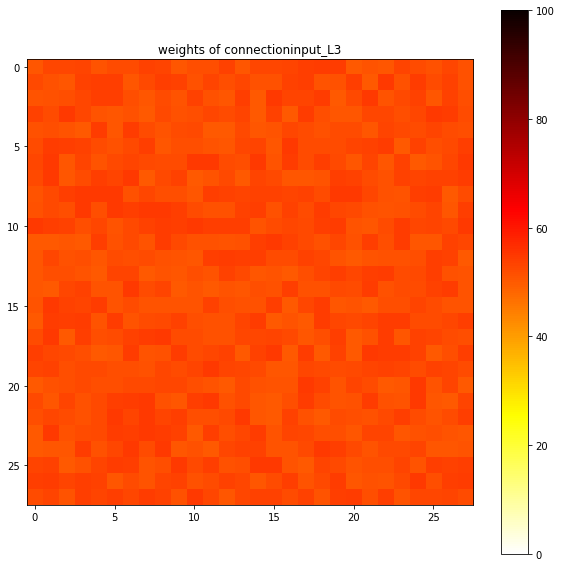

In [23]:
fig_num = 1                                                               # first figure
weight_figures = {}

# input_L3
# weight_figures['input_L3'] = plot_2d_input_weights('input_L3', (784,784), fig_num)
plot_one_to_one('input_L3', 784, fig_num)
fig_num += 1

# # L3_L3
# weight_figures['L3_L3'] = plot_2d_input_weights('L3_L3', (784,784), fig_num)
# fig_num += 1

# # L3_L2
# weight_figures['L3_L2'] = plot_2d_input_weights('L3_L2', (784,784), fig_num)
# fig_num += 1

# # L2_L3
# weight_figures['L2_L3'] = plot_2d_input_weights('L2_L3', (784,784), fig_num)
# fig_num += 1

In [24]:
input_group.rates = 0 * Hz  
net.run(0*second)

run example number: 0 of 10
Starting simulation at t=0. s for a duration of 0.35 s
0.35 (100%) simulated in 4s
run example number: 1 of 10
Starting simulation at t=0.5 s for a duration of 0.35 s
0.35 (100%) simulated in 3s
run example number: 2 of 10
Starting simulation at t=1. s for a duration of 0.35 s
0.35 (100%) simulated in 3s
run example number: 3 of 10
Starting simulation at t=1.5 s for a duration of 0.35 s
0.35 (100%) simulated in 3s
run example number: 4 of 10
Starting simulation at t=2. s for a duration of 0.35 s
0.35 (100%) simulated in 3s
run example number: 5 of 10
Starting simulation at t=2.5 s for a duration of 0.35 s
0.35 (100%) simulated in 3s
run example number: 6 of 10
Starting simulation at t=3. s for a duration of 0.35 s
0.35 (100%) simulated in 2s
run example number: 7 of 10
Starting simulation at t=3.5 s for a duration of 0.35 s
0.35 (100%) simulated in 2s
run example number: 8 of 10
Starting simulation at t=4. s for a duration of 0.35 s
0.35 (100%) simulated in 

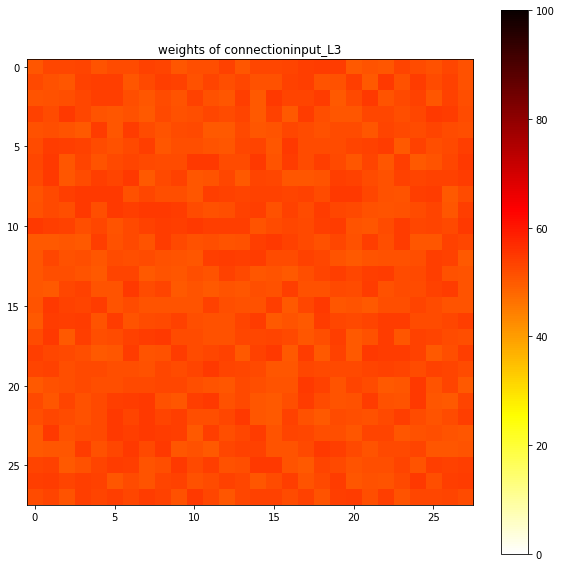

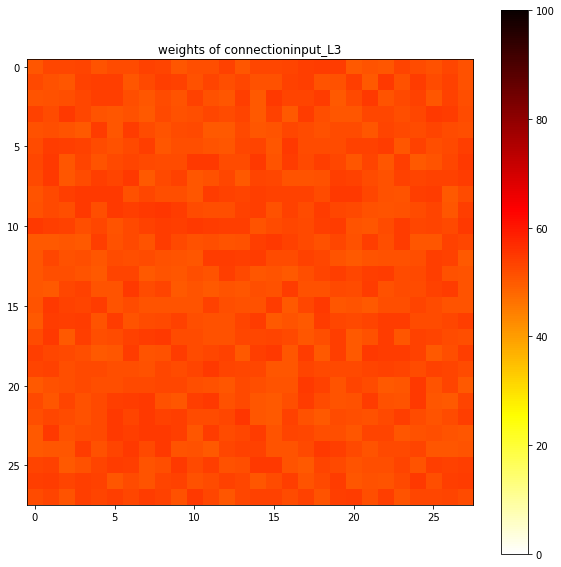

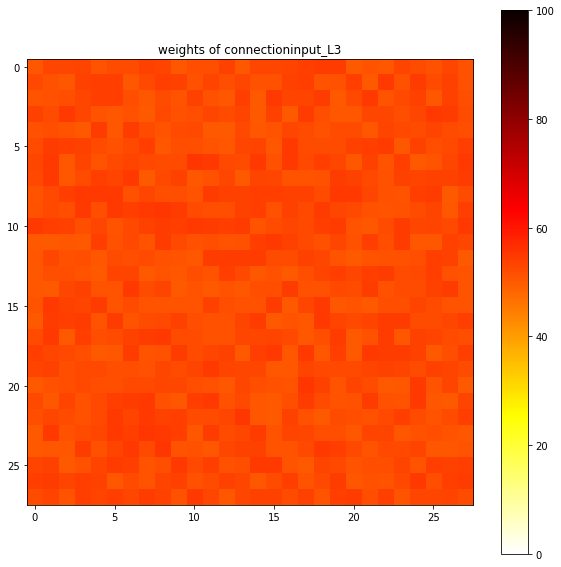

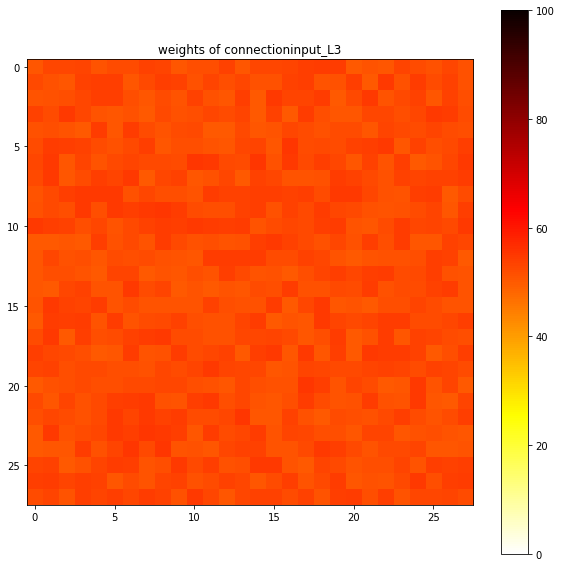

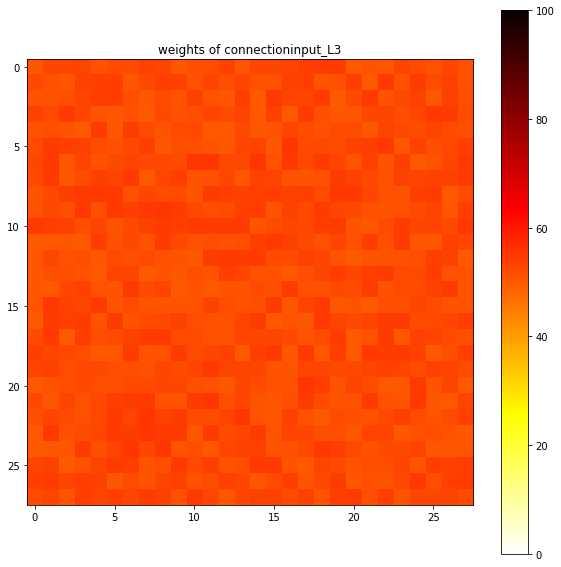

In [25]:
j = 0
while j < (int(num_examples)):
#     normalize_weights()
    
    spike_rates = training['x'][:,:].reshape((n_input)) / 8. *  input_intensity
    
    input_group.rates = spike_rates * Hz
    print('run example number:', j, 'of', int(num_examples))
    
    net.run(single_example_time, report='text')   # 0.35 s

    if j % weight_update_interval == 0:
        plot_one_to_one('input_L3', 784, fig_num)
        fig_num += 1
#         update_2d_input_weights('input_L3', (784,784), weight_figures['input_L3'])
#         fig_num += 1
        
#         update_2d_input_weights('L3_L3', (784,784), weight_figures['L3_L3'])
#         fig_num += 1
        
#         update_2d_input_weights('L3_L2', (784,784), weight_figures['L3_L2'])
#         fig_num += 1
        
#         update_2d_input_weights('L2_L3', (784,784), weight_figures['L2_L3'])
#         fig_num += 1

    current_spike_count = np.asarray(spike_counter.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counter.count[:])
    
    if np.sum(current_spike_count) < 5:
        print("spike count", np.sum(current_spike_count))
        input_intensity += 1
        
        input_group.rates = 0 * Hz
        net.run(resting_time) 
    
    else:                                                   
#         result_monitor[j%update_interval,:] = current_spike_count
#         input_numbers[j] = training['y'][0]

        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', int(num_examples))

        input_group.rates = 0 * Hz
        net.run(resting_time)
        input_intensity = start_input_intensity
        j += 1

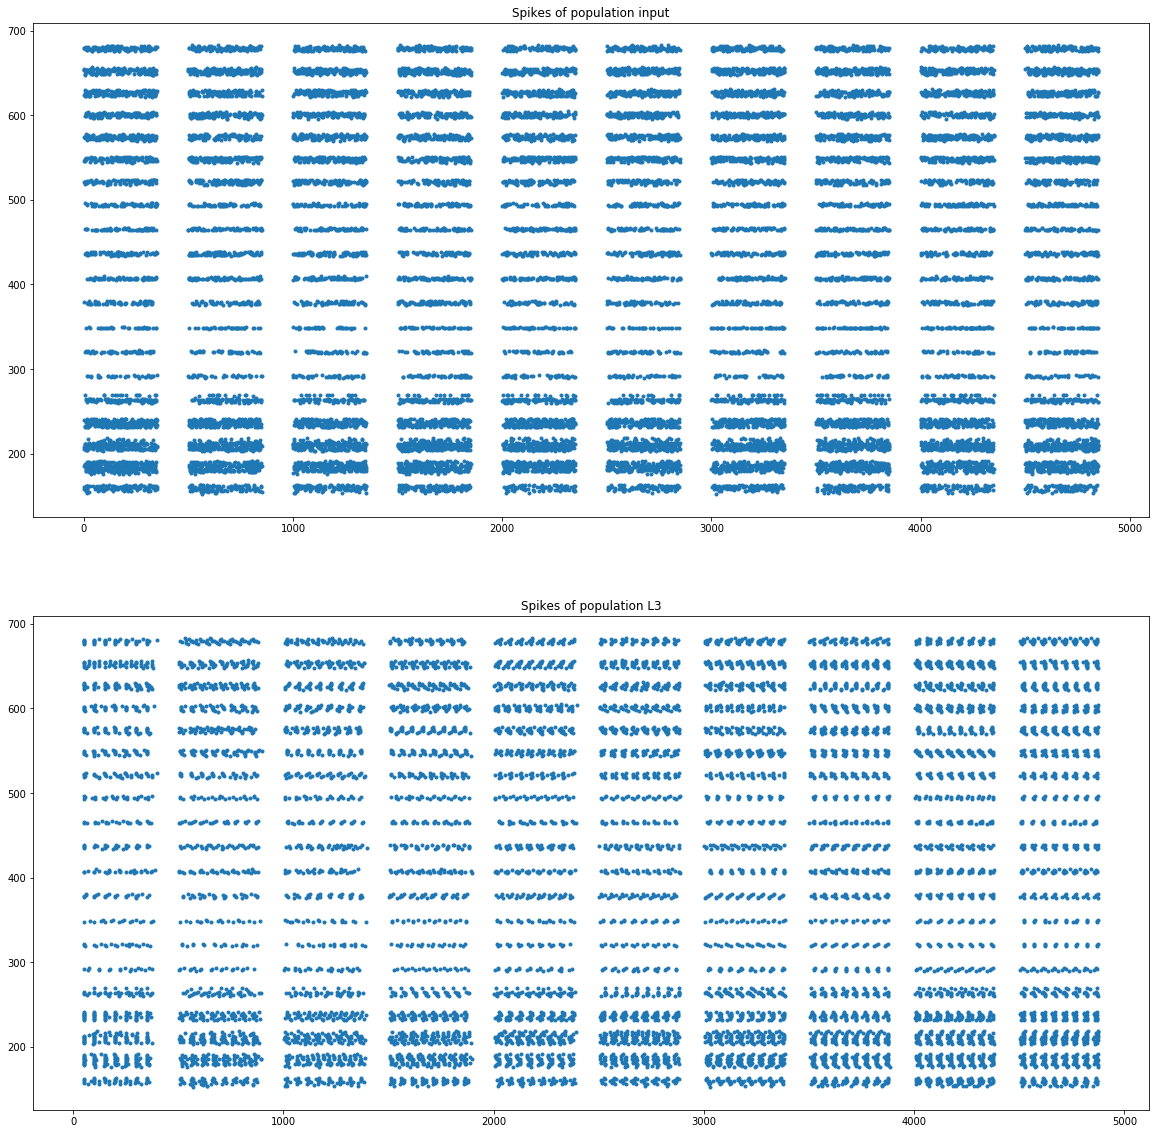

In [26]:
plt.figure(5, figsize=(20,20))

# subplot(3,1,1)

# brian_plot(connections['input_L3'].w)

# plt.figure(6)

# subplot(3,1,1)
# brian_plot(connections['input_L3'].delay)

if spike_monitors:
#     figure(fig_num)
    fig_num += 1
    for i, name in enumerate(spike_monitors):
        subplot(len(spike_monitors), 1, 1+i)
        plot(spike_monitors[name].t/ms, spike_monitors[name].i, '.')
        title('Spikes of population ' + name)

ioff()
show()

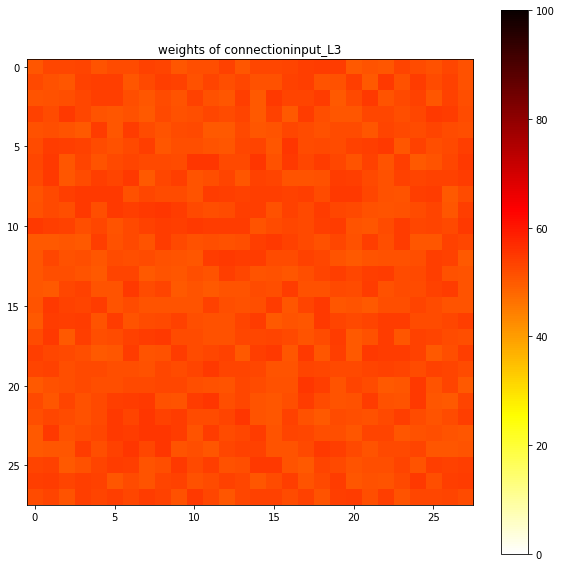

In [27]:
plot_one_to_one('input_L3', 784, fig_num)
fig_num += 1

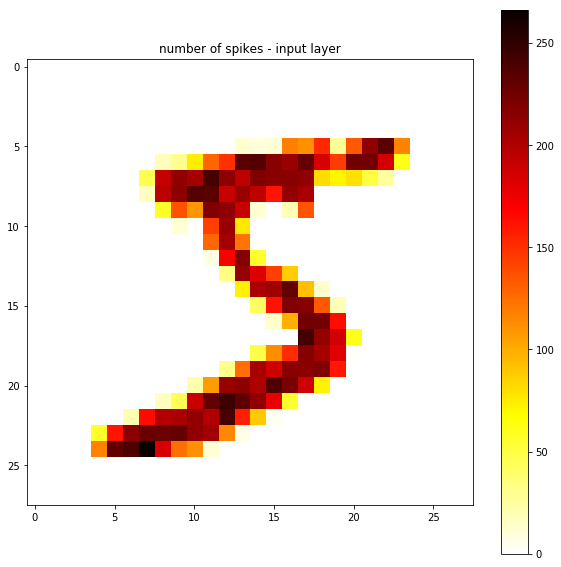

In [28]:
plot_spike_counts('input', (28,28), fig_num+1)

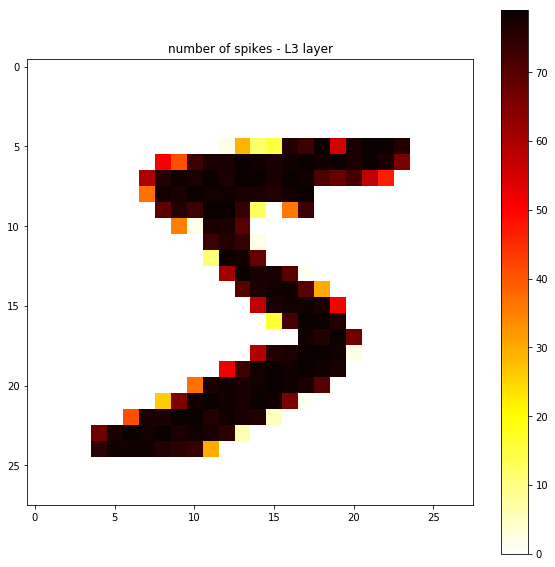

In [29]:
plot_spike_counts('L3', (28,28), fig_num+1)

In [ ]:
def normalize_weights():
    for connName in connections:                                             # XeAe, AeAi, AiAe
        len_source = len(connections[connName].source)                   # 784 = 28*28
        len_target = len(connections[connName].target)                   # 225 = 15*15
        weight_matrix = np.zeros((len_source, len_target))                  # (784,225)
        weight_matrix[connections[connName].i, connections[connName].j] = connections[connName].w
        temp_weights = np.copy(weight_matrix)                                  # why make temp ???????????
        colSums = np.sum(temp_weights, axis = 0)
        colFactors = weight[connName]/colSums                         # 78.0/value of each n_e neuron sum
        for j in range(len_target):                  # for each n_e
            temp_weights[:,j] *= colFactors[j]   # weight = (weight*78.0) / (sum of input weights for each n_e neuron)
        connections[connName].w = temp_weights[connections[connName].i, connections[connName].j]

In [ ]:
connName = 'input_L3'

In [ ]:
len_source = len(connections[connName].source)
len_target = len(connections[connName].target)
weight_matrix = np.zeros((len_source, len_target)) 
weight_matrix[connections[connName].i, connections[connName].j] = connections[connName].w

In [ ]:
weight_matrix.shape

In [ ]:
temp_weights = np.copy(weight_matrix) 

In [ ]:
colSums = np.sum(temp_weights)

In [ ]:
colSums

In [ ]:
connections['input_L3'].w.shape

In [ ]:
training['x'][23,5]

In [30]:
connections['input_L3'].w[(28*23+5)*(784+1)]

73.856700795712

In [31]:
weightMatrix = get_matrix_from_file(weight_path + 'input_L3.npy', (784,784))

(784, 3) ./experiment_2/random/input_L3.npy


In [32]:
weightMatrix[23*28+5][23*28+5]

73.45072660913776

In [13]:
type(training['x'])

numpy.ndarray

In [18]:
from PIL import Image

In [32]:
img = Image.open('./experiment_2/pic.tif')
img.load()
data = np.asarray( img, dtype="int32" )

In [33]:
data

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255,
        255,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37, 255,
        255, 255],
       [255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255,
        255,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37, 255,
        255, 255],
       [255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255,
        255,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37,  37, 255,
        255, 255],
       [25

In [34]:
np.absolute(data-255)[15]

array([  0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,
         0, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,   0,
         0,   0])